In [84]:
!pip install numpy scipy
!pip install scikit-learn
!pip install seaborn
!pip install statsmodels
!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.model_selection import train_test_split
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.6/628.6 kB 3.1 MB/s eta 0:00:00? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.9 MB/s eta 0:00:004.2 MB/s eta 0:00:01


In [ ]:
# Get Bitcoin prices from CoinGecko to predict tomorrow's "Open" price using 
# ARIMA (AutoRegressive Integrated Moving Average) on 1 year of data

In [26]:
test_size=0.2
random_state=42

df = pd.read_csv('bitcoin_data.csv', parse_dates=['timestamp'], index_col='timestamp')
df = df.sort_index()
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=random_state)

In [27]:
print(df.info())
print("\nFirst few rows of the data:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2023-08-22 00:00:00 to 2024-08-20 00:40:44
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         366 non-null    float64
 1   market_cap    366 non-null    float64
 2   total_volume  366 non-null    float64
dtypes: float64(3)
memory usage: 11.4 KB
None

First few rows of the data:
                   price    market_cap  total_volume
timestamp                                           
2023-08-22  26119.005959  5.084919e+11  9.377753e+09
2023-08-23  26033.675407  5.063562e+11  1.370294e+10
2023-08-24  26450.008625  5.149558e+11  1.460057e+10
2023-08-25  26134.934255  5.089070e+11  1.196132e+10
2023-08-26  26044.036209  5.070079e+11  2.582214e+09


In [28]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
              price    market_cap  total_volume
count    366.000000  3.660000e+02  3.660000e+02
mean   50291.870600  9.880036e+11  2.543291e+10
std    15390.335595  3.055196e+11  1.565540e+10
min    25133.303107  4.895030e+11  4.048064e+08
25%    37361.685403  7.311355e+11  1.422390e+10
50%    51777.241242  1.017073e+12  2.249940e+10
75%    64842.378247  1.277907e+12  3.305535e+10
max    73097.767027  1.436631e+12  1.202460e+11


In [10]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
price           0
market_cap      0
total_volume    0
dtype: int64


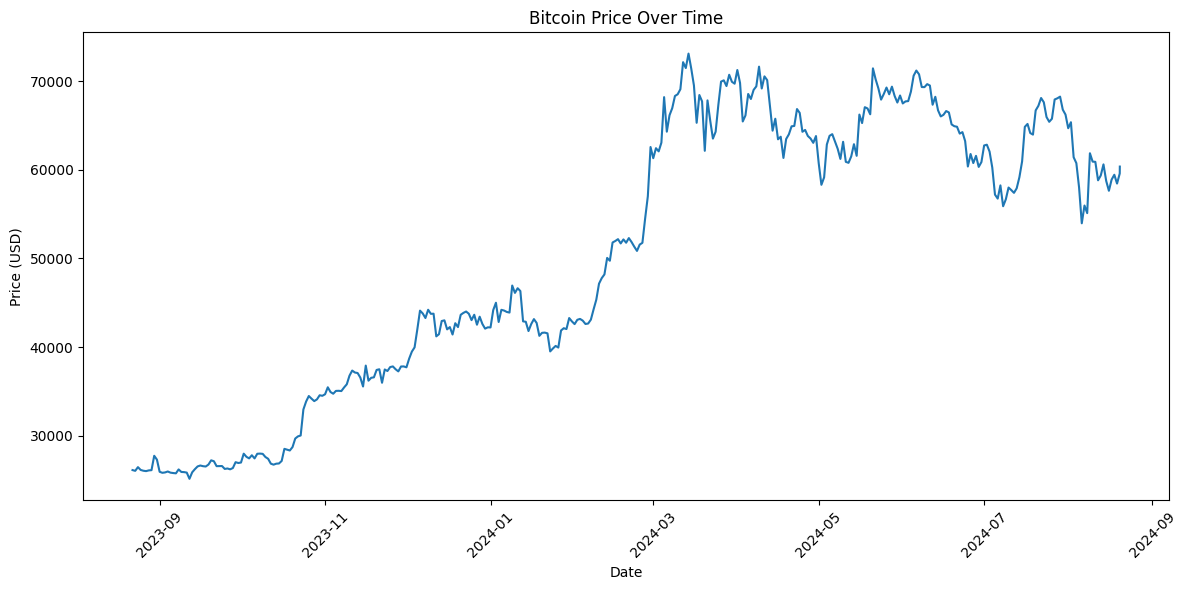

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'])
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

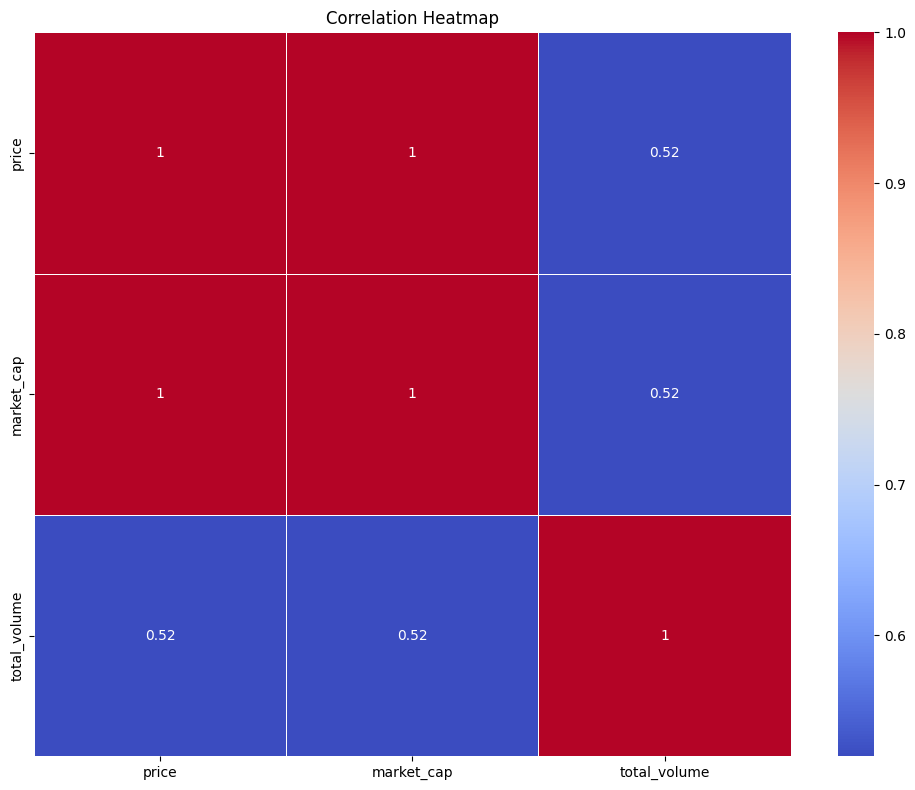

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

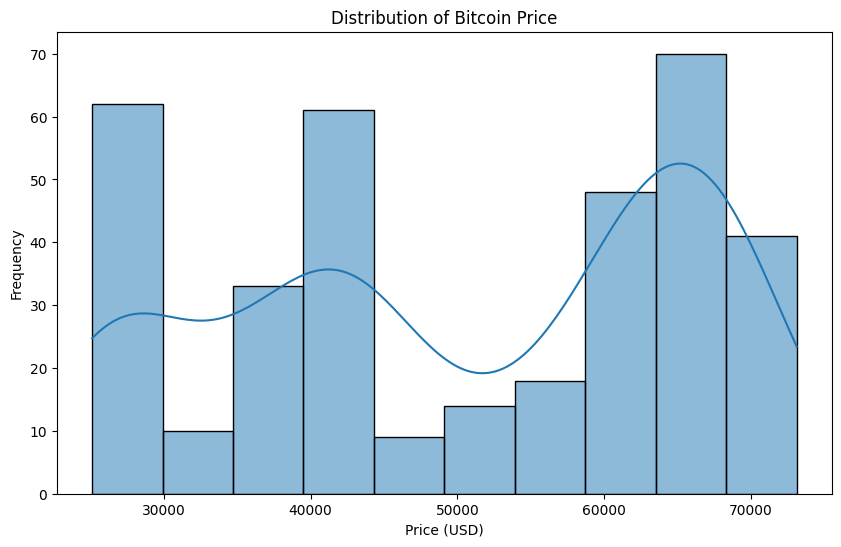

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Bitcoin Price')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

In [17]:
df['daily_return'] = df['price'].pct_change()

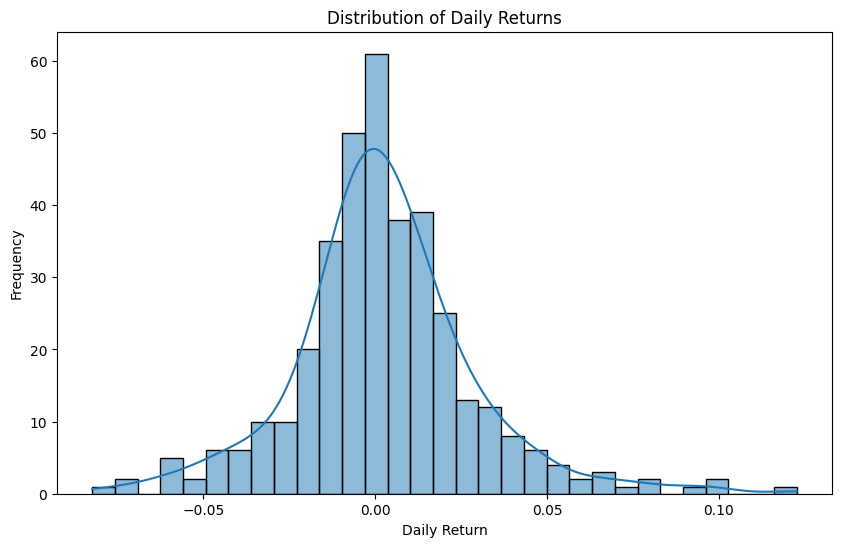

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df['daily_return'].dropna(), kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

In [19]:
print("\nSummary statistics of daily returns:")
print(df['daily_return'].describe())


Summary statistics of daily returns:
count    365.000000
mean       0.002641
std        0.026395
min       -0.082359
25%       -0.010333
50%        0.000821
75%        0.014005
max        0.122669
Name: daily_return, dtype: float64


In [29]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [30]:
print("\nTraining set shape:", train.shape)
print("Testing set shape:", test.shape)


Training set shape: (292, 3)
Testing set shape: (74, 3)


In [31]:
arima_model = ARIMA(train['price'], order=(1,1,1))
arima_results = arima_model.fit()

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [32]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [33]:
arima_forecast = arima_results.forecast(steps=len(test))

In [36]:
arima_performance = evaluate_model(test['price'], arima_forecast)
print("ARIMA Model Performance:")
print(arima_performance)

ARIMA Model Performance:
{'MSE': 64316268.67074785, 'RMSE': 8019.742431696161, 'MAE': 6954.777718057921, 'R2': -3.006651237296172}


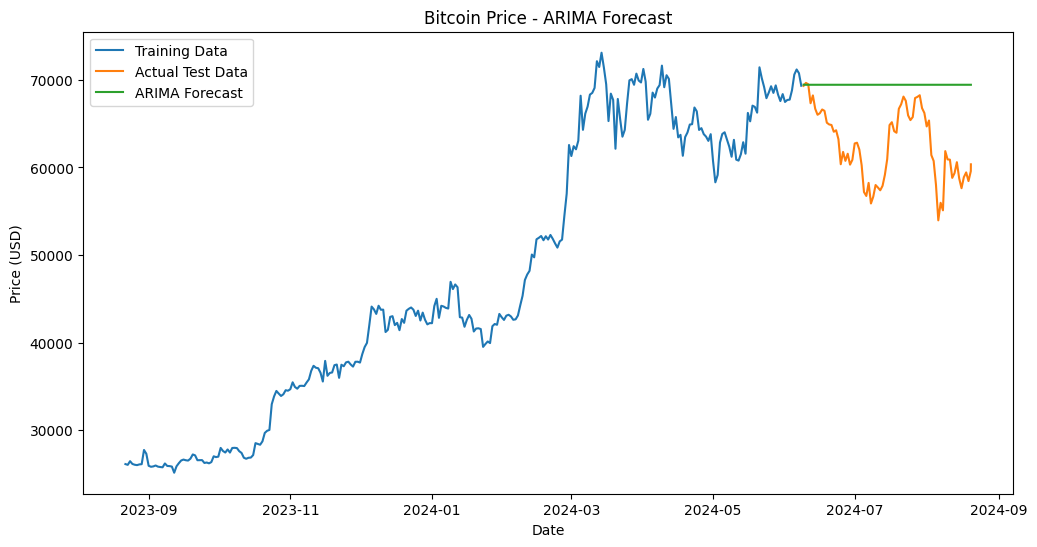

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['price'], label='Training Data')
plt.plot(test.index, test['price'], label='Actual Test Data')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('Bitcoin Price - ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Get Bitcoin prices from CoinGecko to predict tomorrow's "Open" price using 
# Random Forest on 1 year of data

In [38]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [39]:
df_features = create_features(df)

In [40]:
features = [col for col in df_features.columns if col != 'price']
X = df_features[features]
y = df_features['price']

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [43]:
rf_predictions = rf_model.predict(X_test_scaled)

In [44]:
rf_performance = evaluate_model(y_test, rf_predictions)
print("\nRandom Forest Model Performance:")
print(rf_performance)


Random Forest Model Performance:
{'MSE': 352396.9893206735, 'RMSE': 593.6303473717238, 'MAE': 390.6049922868604, 'R2': 0.9780470499538899}


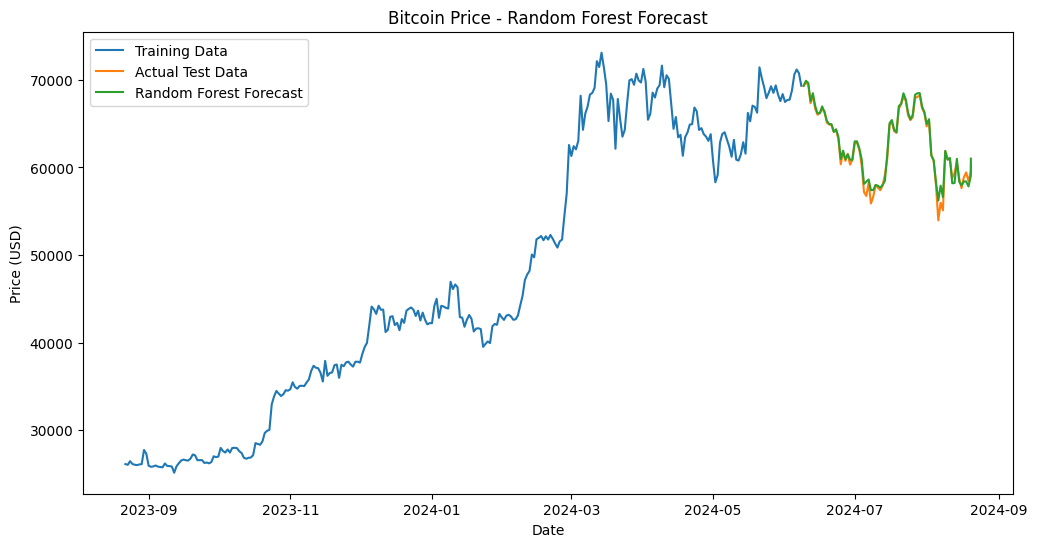

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label='Training Data')
plt.plot(test.index, y_test, label='Actual Test Data')
plt.plot(test.index, rf_predictions, label='Random Forest Forecast')
plt.title('Bitcoin Price - Random Forest Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [46]:
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

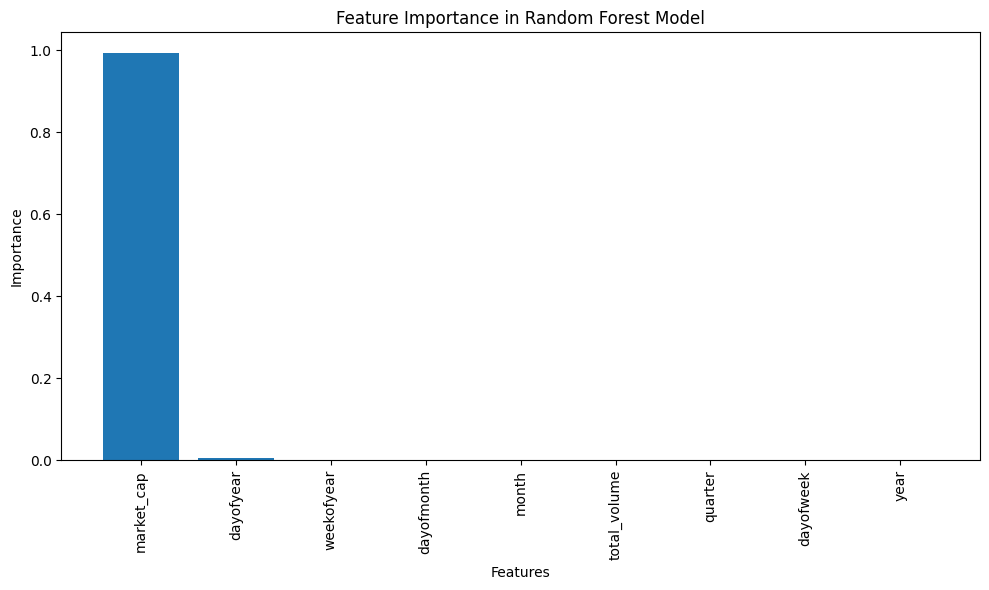

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Get Bitcoin prices from Yahoo Finance to predict tomorrow's "Open" price using 
# Random Forest model on 4 years of data

In [53]:
!pip install yfinance
import yfinance as yf
from datetime import datetime, timedelta

In [66]:
def get_latest_data(symbol='BTC-USD', start_date='2020-01-01'):
    data = yf.download(symbol, start=start_date)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.weekday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Get the latest data
latest_data = get_latest_data()
latest_data.to_csv('updated_bitcoin_data.csv')

# Prepare the data
df = pd.read_csv('updated_bitcoin_data.csv', parse_dates=['Date'], index_col='Date')
df_features = create_features(df)

# Use all columns except 'price' as features
features = [col for col in df_features.columns if col != 'Close']
X = df_features[features]
y = df_features['Close']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Prepare input for today's prediction
today = datetime.now()
today_features = pd.DataFrame({
    'Open': [df['Open'].iloc[-1]],
    'High': [df['High'].iloc[-1]],
    'Low': [df['Low'].iloc[-1]],
    'Volume': [df['Volume'].iloc[-1]],
    'dayofweek': [today.weekday()],
    'quarter': [today.month // 3 + 1],
    'month': [today.month],
    'year': [today.year],
    'dayofyear': [today.timetuple().tm_yday],
    'dayofmonth': [today.day],
    'weekofyear': [today.isocalendar()[1]]
})

# Scale the input
today_scaled = scaler.transform(today_features)

# Make the prediction
prediction = rf_model.predict(today_scaled)

print(f"The predicted Bitcoin price for today ({today.date()}) is: ${prediction[0]:,.2f}")

[*********************100%%**********************]  1 of 1 completed


The predicted Bitcoin price for today (2024-08-20) is: $59,373.54


[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 7366188.395804249
Mean Absolute Error: 1979.78384016639
R-squared Score: 0.9639899201865348


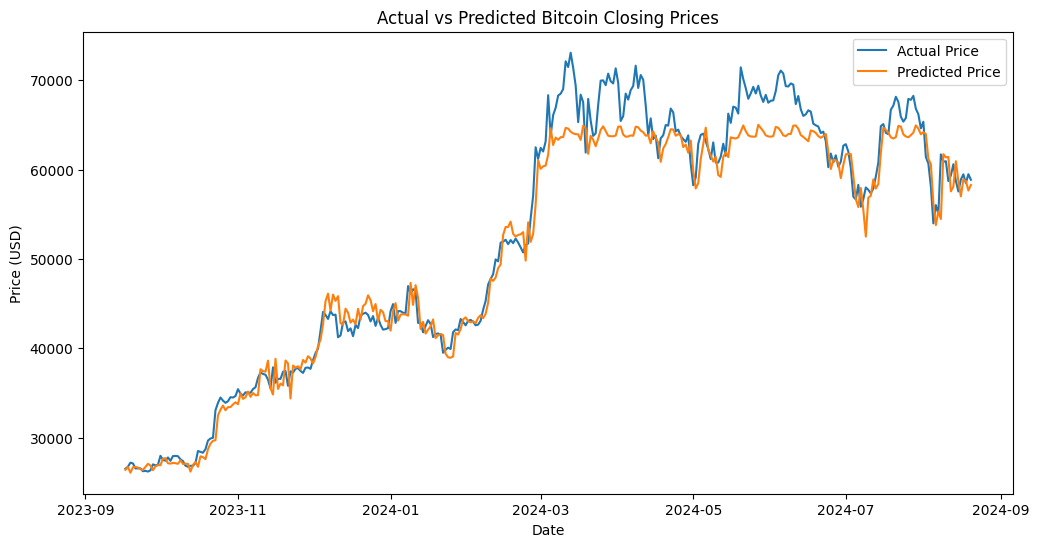


Feature Importance:
              feature  importance
0                Open    0.995739
4         day_of_year    0.001733
5  prev_close_to_open    0.001382
1         day_of_week    0.000619
2               month    0.000286
3                year    0.000241

Today's opening price: $59,470.12
Predicted closing price: $58,279.15


In [68]:
def get_latest_data(symbol='BTC-USD', start_date='2020-01-01'):
    data = yf.download(symbol, start=start_date)
    return data[['Open', 'Close']]

def create_features(df):
    df = df.copy()
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    # Calculate percentage change from previous day's close to today's open
    df['prev_close_to_open'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
    return df

data = get_latest_data()
df = create_features(data)
df = df.dropna()  # Drop rows with NaN values

# Prepare features and target
features = ['Open', 'day_of_week', 'month', 'year', 'day_of_year', 'prev_close_to_open']
X = df[features]
y = df['Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Predict today's closing price
today_open = data['Open'].iloc[-1]
today_features = pd.DataFrame({
    'Open': [today_open],
    'day_of_week': [df.index[-1].dayofweek],
    'month': [df.index[-1].month],
    'year': [df.index[-1].year],
    'day_of_year': [df.index[-1].dayofyear],
    'prev_close_to_open': [(today_open - data['Close'].iloc[-2]) / data['Close'].iloc[-2]]
})

today_prediction = model.predict(today_features)

print(f"\nToday's opening price: ${today_open:,.2f}")
print(f"Predicted closing price: ${today_prediction[0]:,.2f}")

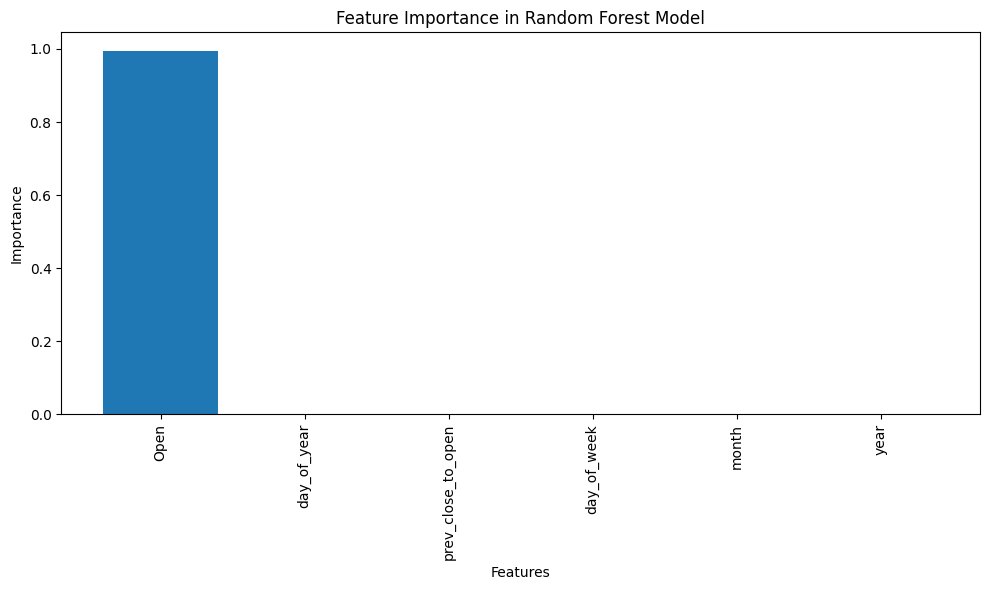

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

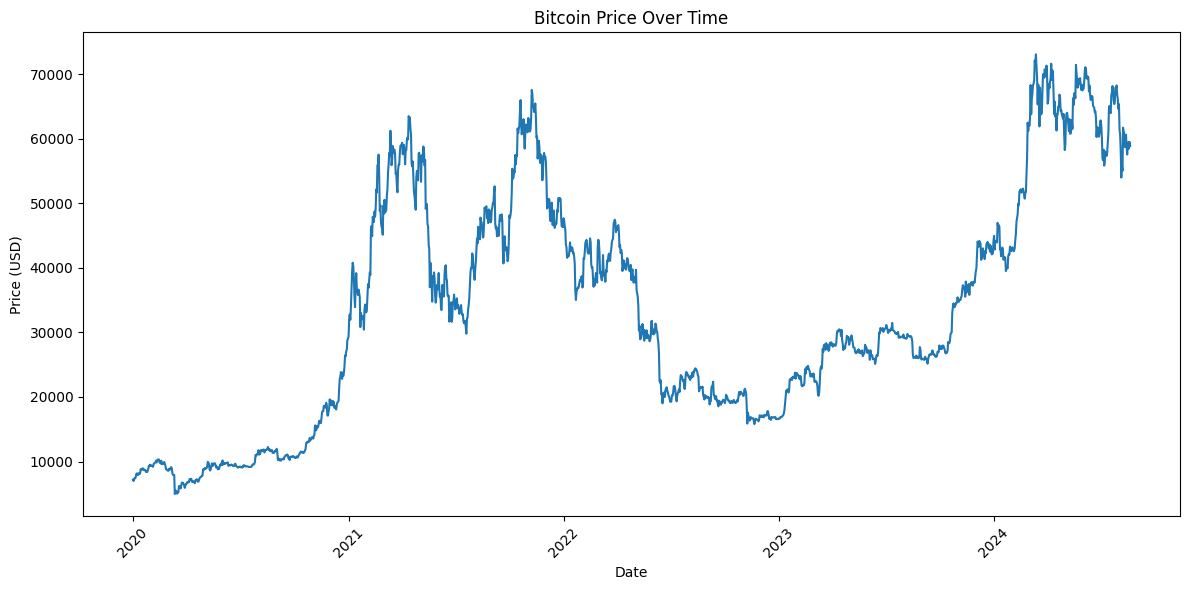

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'])
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Get Bitcoin prices from Yahoo Finance to predict tomorrow's "Open" price using 
# ARIMA (AutoRegressive Integrated Moving Average) on 4 years of data

In [90]:
def get_latest_data(symbol='BTC-USD', start_date='2020-01-01'):
    data = yf.download(symbol, start=start_date)
    return data['Close']

prices = get_latest_data()
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=7,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())
optimal_order = stepwise_model.order

model = ARIMA(train, order=optimal_order)
results = model.fit()

predictions = results.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

next_day = results.forecast(steps=1)
last_price = prices.iloc[-1]
print(f"\nLast known price: ${last_price:.2f}")
print(f"Predicted price for next day: ${next_day.iloc[0]:.2f}")

[*********************100%%**********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=23860.350, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=23439.579, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=23861.658, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=23288.406, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.03 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=23289.890, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=23287.661, Time=1.30 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=23440.622, Time=0.54 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.17 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.92 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=23289.660, Time=1.78 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time=1.9

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


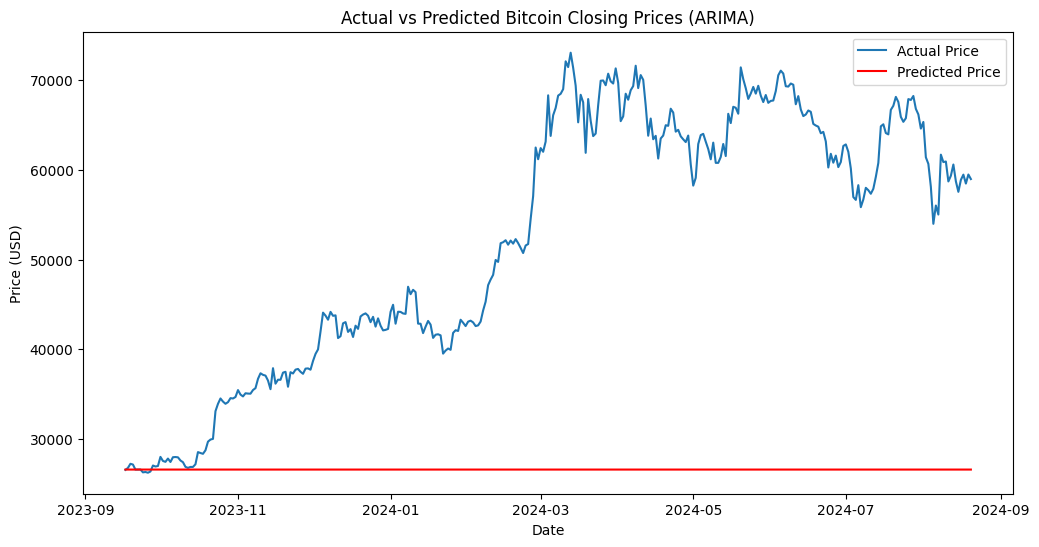

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Price')
plt.plot(test.index, predictions, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Bitcoin Closing Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Get Bitcoin prices from Yahoo Finance to predict tomorrow's "Open" price using 
# ARIMA (AutoRegressive Integrated Moving Average) on 6 months of data

In [93]:
def get_latest_data(symbol='BTC-USD', start_date='2024-01-01'):
    data = yf.download(symbol, start=start_date)
    return data['Close']

prices = get_latest_data()
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=7,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())
optimal_order = stepwise_model.order

model = ARIMA(train, order=optimal_order)
results = model.fit()

predictions = results.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

next_day = results.forecast(steps=1)
last_price = prices.iloc[-1]
print(f"\nLast known price: ${last_price:.2f}")
print(f"Predicted price for next day: ${next_day.iloc[0]:.2f}")

[*********************100%%**********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=3252.297, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3275.241, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3255.855, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3250.392, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=3277.198, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=3234.232, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=3255.857, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=3236.223, Time=0.53 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=3243.201, Time=0.31 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=3239.663, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=3255.226, Time=0.09 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=3232.349, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=3244.567, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[7]             : 

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


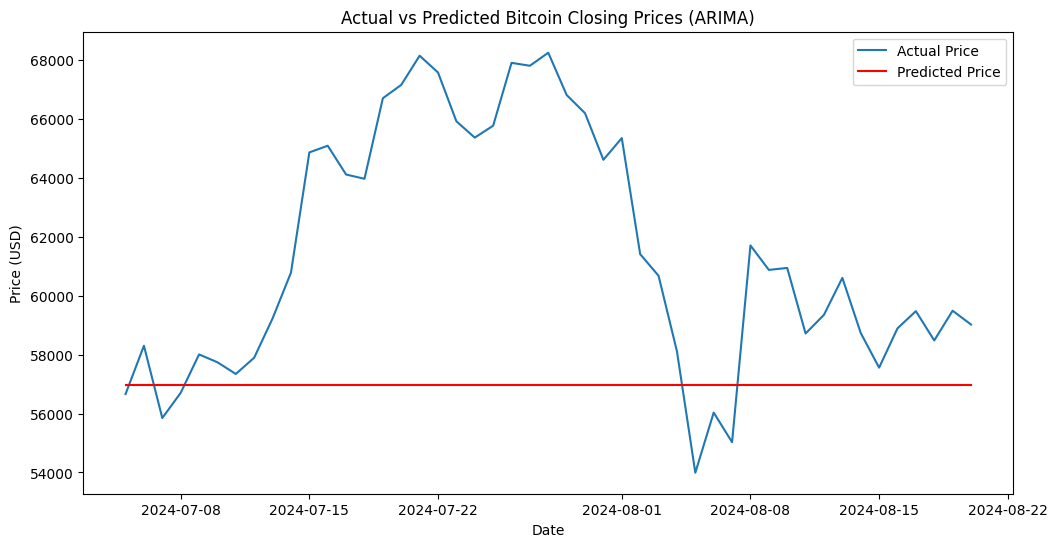

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Price')
plt.plot(test.index, predictions, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Bitcoin Closing Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [116]:
# Get Bitcoin prices from CoinMarketCap to predict tomorrow's "Open" price using 
# ARIMA (AutoRegressive Integrated Moving Average) on 3 hours of data (30 second intervals)

In [142]:
def read_data_from_file(filename='cmc_btc_prices.csv'):
    df = pd.read_csv(filename)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Timestamp', inplace=True)
    df.sort_index(inplace=True)
    return df

df = read_data_from_file()
prices = df['BTC Price (USD)']

prices_resampled = prices.resample('5T').last()

train_size = int(len(prices_resampled) * 0.8)
train, test = prices_resampled[:train_size], prices_resampled[train_size:]

stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, 
                            d=None, max_d=2, 
                            seasonal=False, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())
optimal_order = stepwise_model.order


model = ARIMA(train, order=optimal_order)
results = model.fit()

predictions = results.forecast(steps=len(test))

mse = ((predictions - test) ** 2).mean()
rmse = np.sqrt(mse)
mae = (np.abs(predictions - test)).mean()

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

next_day = results.forecast(steps=1)
last_price = prices.iloc[-1]

print(f"\nLast known price: ${last_price:.2f}")
print(f"Predicted next price: ${next_day.iloc[0]:.2f}")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=175.187, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=349.496, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=343.081, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=339.121, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=166.334, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=157.893, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.260, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=157.618, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=159.549, Time=0.01 sec
 ARIMA

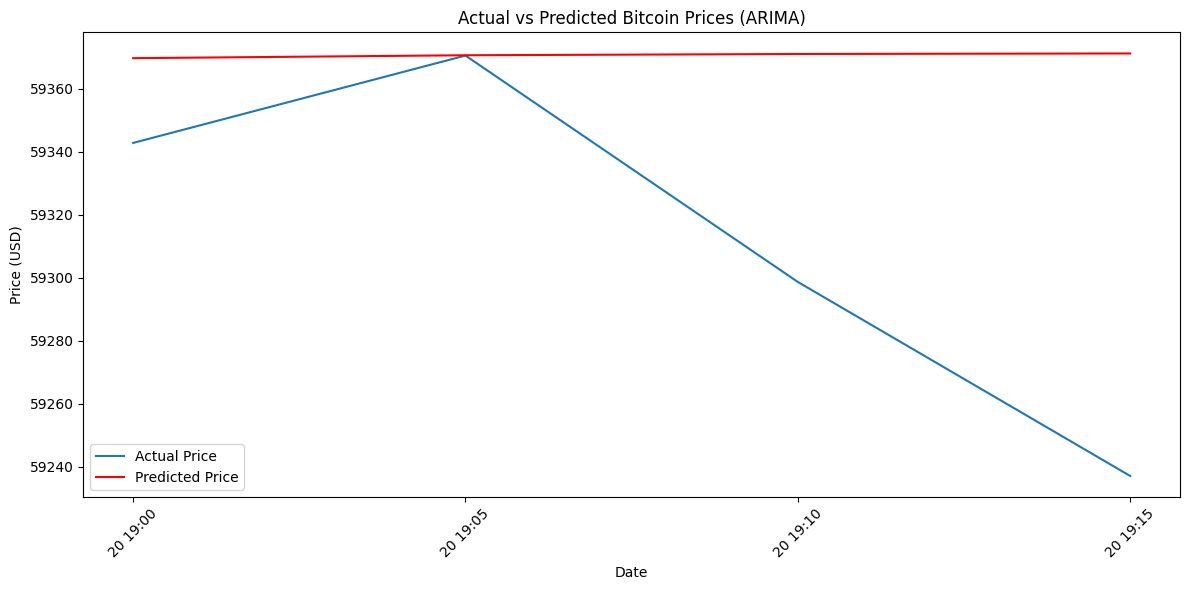

In [143]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Price')
plt.plot(test.index, predictions, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Bitcoin Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()